# Semantic Segmentation Demo

## Imports and utility functions

In [1]:
# System libs
import os, csv, torch, scipy.io, PIL.Image, torchvision.transforms
import os.path as osp
import cv2
import pandas as pd
import numpy as np
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

In [2]:
# read frames from video 
def read_frame_from_videos(vname, res=None):
    frames = []
    vidcap = cv2.VideoCapture(vname)

    while True:
        success, image = vidcap.read()
        if not success:
            return frames
        img = PIL.Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if res is not None:
            img = img.resize(res)
        frames.append(img)
    return frames   

In [3]:
def get_mask(scores, idxs, threshold=0.5):
    pred = np.zeros(scores.shape[1:])
    for idx in idxs:
        pred += scores[idx].numpy()
    pred[pred > threshold] = 1.0
    return pred

In [4]:
def visualize_result(pred):
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(np.uint8)
    display(PIL.Image.fromarray(pred_color))

## Load and show semantic labels

In [5]:
# read labels
labels = pd.read_csv('data/object150_info.csv')
labels = list(labels['Name'])
labels = [lbl.split(';')[0] for lbl in labels]
labels_str = 'Available labels: \n' + '\n'.join([f' - {i:3}: {lbl}' for i, lbl in enumerate(labels)])
print(labels_str)

# load colors
colors = scipy.io.loadmat('data/color150.mat')['colors']

Available labels: 
 -   0: wall
 -   1: building
 -   2: sky
 -   3: floor
 -   4: tree
 -   5: ceiling
 -   6: road
 -   7: bed
 -   8: windowpane
 -   9: grass
 -  10: cabinet
 -  11: sidewalk
 -  12: person
 -  13: earth
 -  14: door
 -  15: table
 -  16: mountain
 -  17: plant
 -  18: curtain
 -  19: chair
 -  20: car
 -  21: water
 -  22: painting
 -  23: sofa
 -  24: shelf
 -  25: house
 -  26: sea
 -  27: mirror
 -  28: rug
 -  29: field
 -  30: armchair
 -  31: seat
 -  32: fence
 -  33: desk
 -  34: rock
 -  35: wardrobe
 -  36: lamp
 -  37: bathtub
 -  38: railing
 -  39: cushion
 -  40: base
 -  41: box
 -  42: column
 -  43: signboard
 -  44: chest
 -  45: counter
 -  46: sand
 -  47: sink
 -  48: skyscraper
 -  49: fireplace
 -  50: refrigerator
 -  51: grandstand
 -  52: path
 -  53: stairs
 -  54: runway
 -  55: case
 -  56: pool
 -  57: pillow
 -  58: screen
 -  59: stairway
 -  60: river
 -  61: bridge
 -  62: bookcase
 -  63: blind
 -  64: coffee
 -  65: toilet
 -  66

## Loading the segmentation model

In [6]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50',
    fc_dim=2048,
    weights='ckpt/upernet50/encoder_epoch_30.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='upernet',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/upernet50/decoder_epoch_30.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): Resnet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, m

## Load test data

In [7]:
step = 25
file_path = '/Users/miccio/dl/data/mexico/input.mp4'
frames = read_frame_from_videos(file_path, (480, 320))
#frames = read_frame_from_videos(file_path, None)
frames = frames[::step]
print('# of frames:', len(frames))

# of frames: 9


In [8]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
img_original = torch.stack([torch.Tensor(np.array(frame)) for frame in frames])
img_data = torch.stack([pil_to_tensor(frame) for frame in frames])
frames_batch = {'img_data': img_data}
img_size = list(img_data.shape[2:])[::-1]
# define size of the generated semantic segmentation results
# in this case, it'll be 1/4 of the input resolution
mask_size = [img_size[1] // 4, img_size[0] // 4]  
print('Data shape (orig/data):', list(img_original.shape), list(img_data.shape))
print('Image shape (orig/mask):', img_size, mask_size)


Data shape (orig/data): [9, 320, 480, 3] [9, 3, 320, 480]
Image shape (orig/mask): [480, 320] [80, 120]


## Run the Model

In [9]:
# Run the segmentation
with torch.no_grad():
    scores = segmentation_module(frames_batch, segSize=mask_size)

## Show all detected classes

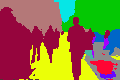

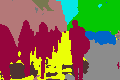

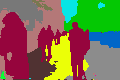

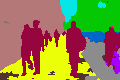

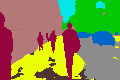

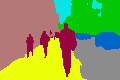

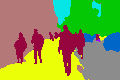

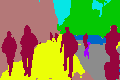

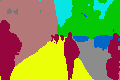

In [10]:
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu().numpy()

for pred_frame in pred:
    visualize_result(pred_frame)

## Perform masking and store frames

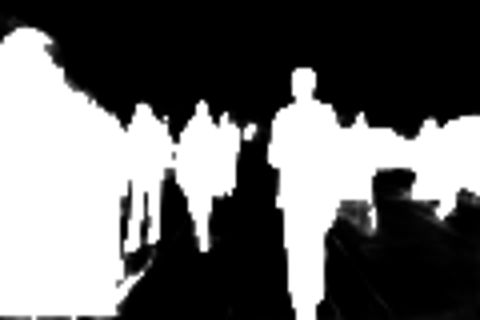

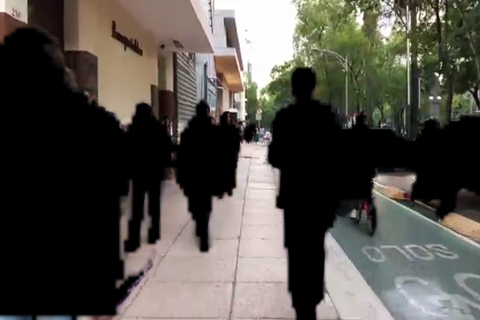

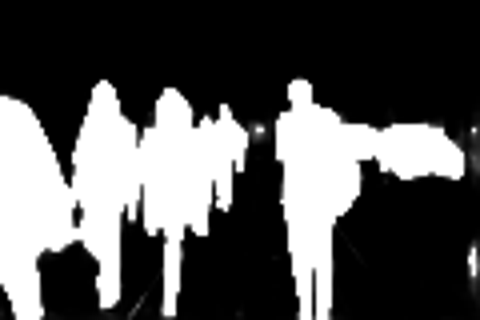

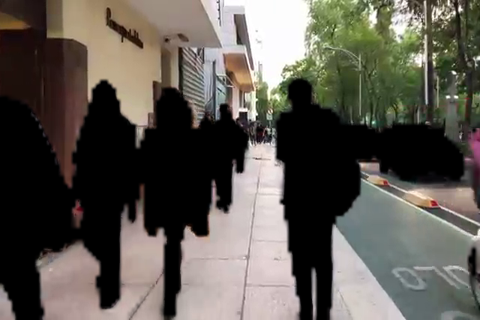

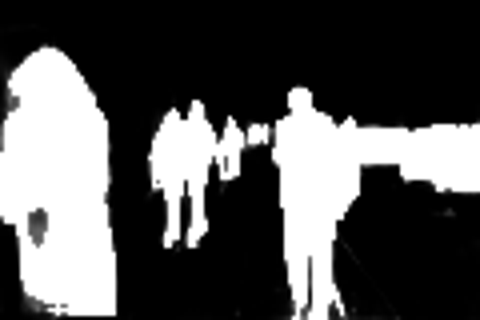

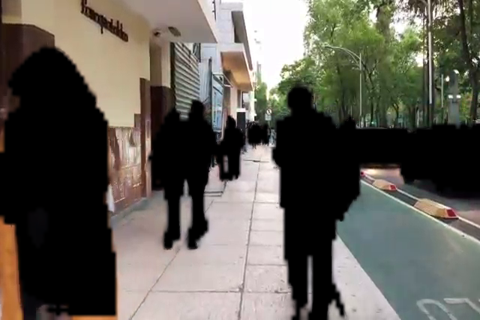

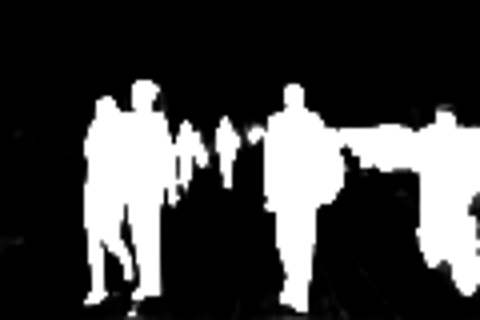

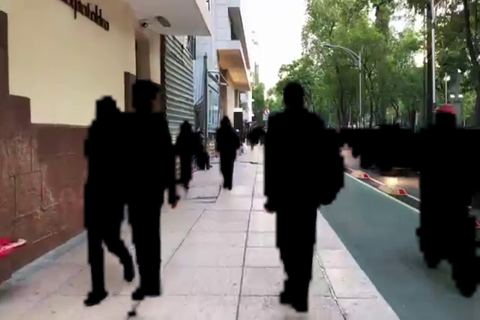

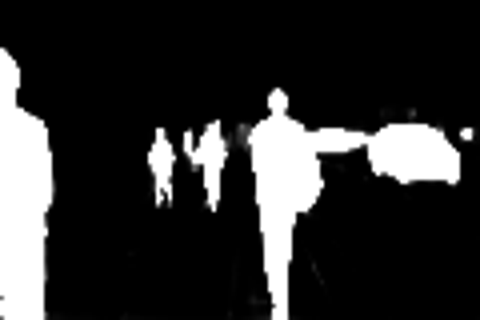

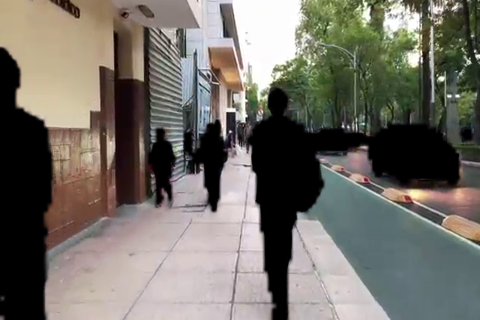

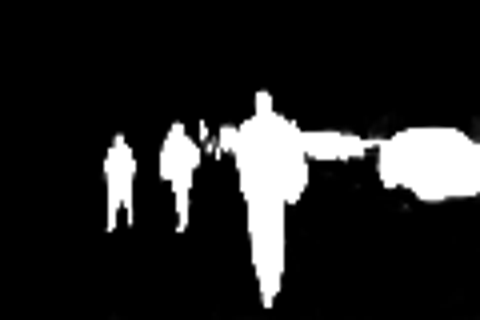

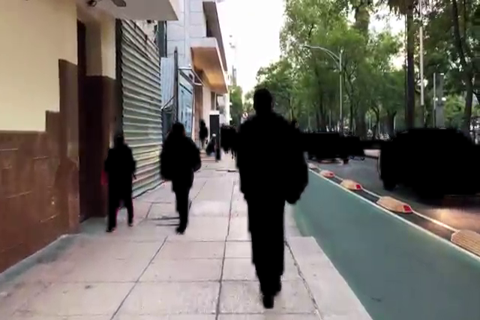

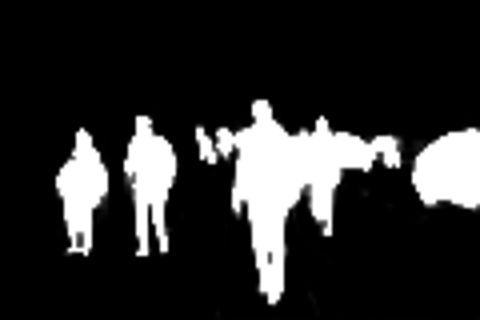

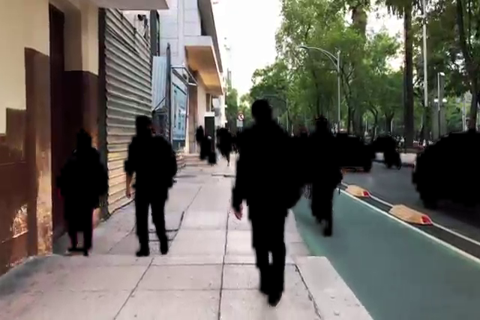

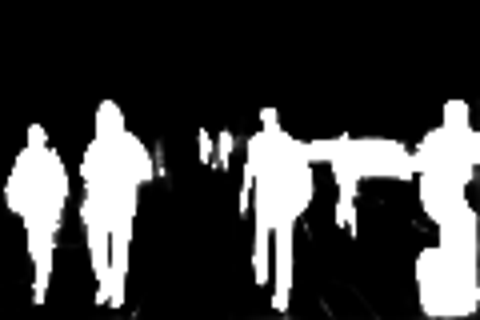

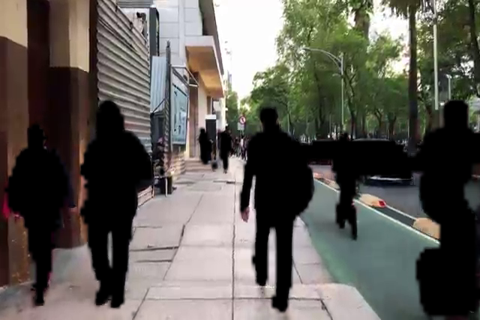

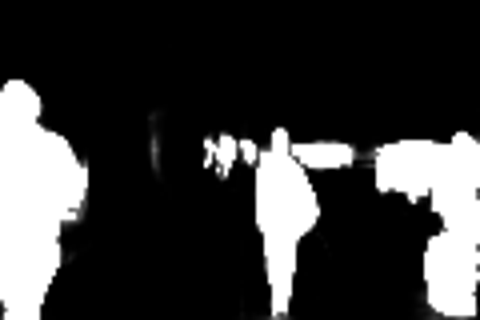

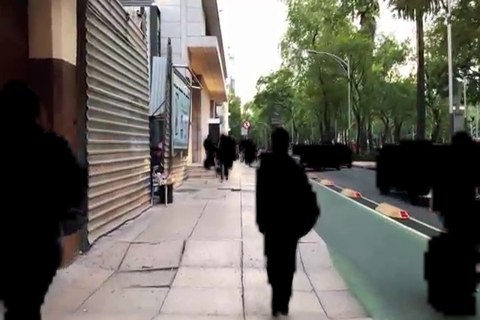

In [11]:
# store frames
dest_path = '/Users/miccio/dl/data/mexico/masks/'
dest_orig_path = '/Users/miccio/dl/data/mexico/orig/'
classes = [12, 20, 116]
black = PIL.Image.new('RGB', img_size, color='black')
for i, imgs in enumerate(zip(scores, img_original)):
    score, orig = imgs
    
    mask = get_mask(score, classes)
    mask_img = PIL.Image.fromarray(np.uint8(mask * 255))
    mask_img = mask_img.resize(img_size)
    mask_path = osp.join(dest_path, f'img{i:04}.png')
    #mask_img.save(mask_path)
    
    #orig = orig.numpy().copy()
    mskorig_img = PIL.Image.fromarray(np.uint8(orig))
    #print(black, mskorig_img, mask_img)
    mskorig_img = PIL.Image.composite(black, mskorig_img, mask_img)
    orig_path = osp.join(dest_orig_path, f'img{i:04}.png')
    #mskorig_img.save(orig_path)
    [display(img) for img in [mask_img, mskorig_img]]
    #if i % 1 == 0:
    #    visualize_result2(mskorig_img, mask)
